# Work on `fct_monthly_operator_summary`

In [1]:
# import datetime
import sys

import _operator_grain_route_dir_visuals as _report_operator_visuals
import _sql_query
import altair as alt

# import google.auth
import pandas as pd
from IPython.display import HTML, Image, Markdown, display, display_html
from shared_utils import gtfs_utils_v2, portfolio_utils, publish_utils
from update_vars import GTFS_DATA_DICT, RT_SCHED_GCS

ROLLUP_DICT = GTFS_DATA_DICT.gtfs_digest_rollup

import _operator_grain_route_dir_visuals
import _operator_grain_scheduled_service

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
analysis_name = "City and County of San Francisco"

In [4]:
def formatted(number):
    return "{:,}".format(number)

In [5]:
ROLLUP_DICT.schedule_route_direction

'mart_gtfs_rollup.fct_monthly_schedule_route_direction_summary'

In [6]:
df = _sql_query.download_with_pandas_gbq(
    project="cal-itp-data-infra-staging",
    filename="tiffany_mart_gtfs_rollup.fct_monthly_operator_summary",
)


        SELECT 
            *
        FROM `cal-itp-data-infra-staging`.`tiffany_mart_gtfs_rollup`.`fct_monthly_operator_summary`
        WHERE month_first_day >=  DATE('2025-01-01')
    


/opt/conda/lib/python3.11/site-packages/pandas_gbq/gbq.py:38: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa


Downloading: 100%|██████████|
download time: 0:00:01.812148


In [7]:
df.sample().T

,1209
month,9
year,2025
month_first_day,2025-09-01 00:00:00
schedule_name,County Connection Schedule
schedule_base64_url,aHR0cDovL2NjY3RhLm9yZy9HVEZTL2dvb2dsZV90cmFuc2l0LnppcA==
vp_name,County Connection Swiftly Vehicle Position
vp_base64_url,aHR0cHM6Ly9hcGkuZ29zd2lmdC5seS9yZWFsLXRpbWUvY291bnR5LWNvbm5lY3Rpb24vZ3Rmcy1ydC12ZWhpY2xlLXBvc2l0aW9ucw==
tu_name,County Connection Swiftly Trip Update
tu_base64_url,aHR0cHM6Ly9hcGkuZ29zd2lmdC5seS9yZWFsLXRpbWUvY291bnR5LWNvbm5lY3Rpb24vZ3Rmcy1ydC10cmlwLXVwZGF0ZXM=
day_type,Sunday


## Cleaning

In [8]:
df2 = df[
    [
        "month_first_day",
        "analysis_name",
        "vp_name",
        "tu_name",
        "n_trips",
        "day_type",
        "daily_trips",
        "ttl_service_hours",
        "n_routes",
        "n_days",
        "vp_messages_per_minute",
        "n_vp_trips",
        "daily_vp_trips",
        "pct_vp_trips",
        "n_vp_routes",
        "pct_vp_service_hours",
        "tu_messages_per_minute",
        "n_tu_trips",
        "daily_tu_trips",
        "pct_tu_trips",
        "n_tu_routes",
        "pct_tu_service_hours",
    ]
]

In [9]:
# df2 = df.sort_values(by=["month_first_day"], ascending=False).drop_duplicates(
#    subset=["analysis_name"]
# )

In [10]:
df2.columns = df2.columns.str.replace("_", " ").str.title()

In [11]:
# df2["Month First Day"] = pd.to_datetime(df2["Month First Day"]).dt.strftime(
#   "%B %Y"
# )

In [12]:
df2 = df2.rename(
    columns={
        "Month First Day": "Date",
    }
)

In [13]:
df2.columns = df2.columns.str.replace("Vp", "VP").str.replace("Tu", "TU")

In [14]:
df2["TU Messages Per Second"] = 60 / df2["TU Messages Per Minute"]

In [15]:
df2["VP Messages Per Second"] = 60 / df2["VP Messages Per Minute"]

In [16]:
df2.sample()

,Date,Analysis Name,VP Name,TU Name,N Trips,Day Type,Daily Trips,Ttl Service Hours,N Routes,N Days,VP Messages Per Minute,N VP Trips,Daily VP Trips,Pct VP Trips,N VP Routes,Pct VP Service Hours,TU Messages Per Minute,N TU Trips,Daily TU Trips,Pct TU Trips,N TU Routes,Pct TU Service Hours,TU Messages Per Second,VP Messages Per Second
2160,2025-09-01,City of Pasadena,Pasadena VehiclePositions,Pasadena TripUpdates,1068,Sunday,267.00,205760.80,8.00,4,3.10,1046,261.50,0.98,1.00,0.00,3.00,1057,264.30,0.99,1.00,0.01,20.00,19.35


In [17]:
df2["Percent of Trips with Trip Updates"] = (df2["N TU Trips"] / df2["N Trips"]) * 100

In [18]:
df2["Percent of Trips with Vehicle Positions"] = (
    df2["N VP Trips"] / df2["N Trips"]
) * 100

In [19]:
df2["Percent of Trips with Vehicle Positions"].describe()

count   3567.00
mean      86.38
std       24.09
min        0.07
25%       83.33
50%       95.08
75%       98.96
max      301.22
Name: Percent of Trips with Vehicle Positions, dtype: Float64

In [20]:
df2["Percent of Trips with Vehicle Positions"] = df2[
    "Percent of Trips with Vehicle Positions"
].clip(upper=100.0)
df2["Percent of Trips with Trip Updates"] = df2[
    "Percent of Trips with Trip Updates"
].clip(upper=100.0)

In [22]:
sf_only = df2.loc[df2["Analysis Name"] == analysis_name]

In [23]:
sf_only.shape

(33, 26)

**Question: How can VP Trips per higher than N Trips?**

In [24]:
tu_df_min = _operator_grain_route_dir_visuals.circle_chart(
    df=sf_only.loc[sf_only["Day Type"] == "Weekday"],
    x_col="Date",
    y_col="TU Messages Per Minute",
    color_col="TU Messages Per Minute",
    color_scheme=["#ccbb44", "#5b8efd", "#dd217d"],
    tooltip_cols=["Date", "TU Messages Per Minute"],
    date_format="%b %Y",
)

In [25]:
_operator_grain_route_dir_visuals.configure_chart(
    tu_df_min,
    width=400,
    height=250,
    title="Trip Update Messages per Minute",
    subtitle="Description",
)

alt.Chart(...)

In [26]:
tu_df_sec = _operator_grain_route_dir_visuals.circle_chart(
    df=sf_only.loc[sf_only["Day Type"] == "Weekday"],
    x_col="Date",
    y_col="TU Messages Per Second",
    color_col="TU Messages Per Second",
    color_scheme=["#ccbb44", "#5b8efd", "#dd217d"],
    tooltip_cols=["Date", "TU Messages Per Second"],
    date_format="%b %Y",
).encode(y=alt.Y("TU Messages Per Second", scale=alt.Scale(domain=[0, 60], clamp=True)))

In [27]:
_operator_grain_route_dir_visuals.configure_chart(
    tu_df_sec,
    width=400,
    height=250,
    title="Trip Update Messages per Seconds",
    subtitle="Description",
)

alt.Chart(...)

### Planners/Agencies - Vehicle Positions per Minute

In [28]:
vp_df = _operator_grain_route_dir_visuals.circle_chart(
    df=sf_only.loc[sf_only["Day Type"] == "Weekday"],
    x_col="Date",
    y_col="VP Messages Per Minute",
    color_col="VP Messages Per Minute",
    color_scheme=["#ccbb44", "#5b8efd", "#dd217d"],
    tooltip_cols=["Date", "VP Messages Per Minute"],
    date_format="%b %Y",
)

In [29]:
_operator_grain_route_dir_visuals.configure_chart(
    vp_df,
    width=400,
    height=250,
    title="Vehicle Positions per Minute",
    subtitle="Description",
)

alt.Chart(...)

### Planners/Agencies: % of Trips with TU & % of Trips with VP 

In [31]:
sf_only.sample()

,Date,Analysis Name,VP Name,TU Name,N Trips,Day Type,Daily Trips,Ttl Service Hours,N Routes,N Days,VP Messages Per Minute,N VP Trips,Daily VP Trips,Pct VP Trips,N VP Routes,Pct VP Service Hours,TU Messages Per Minute,N TU Trips,Daily TU Trips,Pct TU Trips,N TU Routes,Pct TU Service Hours,TU Messages Per Second,VP Messages Per Second,Percent of Trips with Trip Updates,Percent of Trips with Vehicle Positions
1609,2025-07-01,City and County of San Francisco,Bay Area 511 Muni VehiclePositions,Bay Area 511 Muni TripUpdates,31412,Sunday,7853.00,69188339.60,60.00,4,3.00,28247,7061.80,0.90,1.00,0.00,2.90,28773,7193.30,0.92,1.00,0.00,20.69,20.00,91.60,89.92


In [42]:
sf_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 416 to 2705
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Date                                     33 non-null     datetime64[ns]
 1   Analysis Name                            33 non-null     object        
 2   VP Name                                  33 non-null     object        
 3   TU Name                                  33 non-null     object        
 4   N Trips                                  33 non-null     Int64         
 5   Day Type                                 33 non-null     object        
 6   Daily Trips                              33 non-null     float64       
 7   Ttl Service Hours                        33 non-null     float64       
 8   N Routes                                 33 non-null     float64       
 9   N Days                                   

In [32]:
sf_only.columns

Index(['Date', 'Analysis Name', 'VP Name', 'TU Name', 'N Trips', 'Day Type',
       'Daily Trips', 'Ttl Service Hours', 'N Routes', 'N Days',
       'VP Messages Per Minute', 'N VP Trips', 'Daily VP Trips',
       'Pct VP Trips', 'N VP Routes', 'Pct VP Service Hours',
       'TU Messages Per Minute', 'N TU Trips', 'Daily TU Trips',
       'Pct TU Trips', 'N TU Routes', 'Pct TU Service Hours',
       'TU Messages Per Second', 'VP Messages Per Second',
       'Percent of Trips with Trip Updates',
       'Percent of Trips with Vehicle Positions'],
      dtype='object')

### Can't get colors for line charts to work.

In [53]:
(
    alt.Chart(sf_only.loc[sf_only["Day Type"] == "Weekday"])
    .mark_line(size=3)
    .encode(
        x=alt.X(
            "Date",
            title="Date",
            axis=alt.Axis(labelAngle=-45, format="%b %Y"),
        ),
        y=alt.Y(
            "Percent of Trips with Trip Updates:Q",
            title="Percent of Trips with Trip Updates",
        ),
        tooltip=[
            "Date",
            "Percent of Trips with Trip Updates",
        ],
    )
)

alt.Chart(...)

In [45]:
_operator_grain_route_dir_visuals.line_chart(
    df=sf_only.loc[sf_only["Day Type"] == "Weekday"],
    x_col="Date",
    y_col="Percent of Trips with Trip Updates",
    color_col="Percent of Trips with Trip Updates",
    color_scheme=[
        "#5b8efd",
        "#765fec",
        "#fcb40e",
        "#fc5c04",
        "#dd217d",
        "#ccbb44",
        "#c5c5c4",
    ],
    tooltip_cols=[
        "Date",
        "Percent of Trips with Trip Updates",
    ],
    date_format="%b %Y",
)

alt.Chart(...)

## CT District
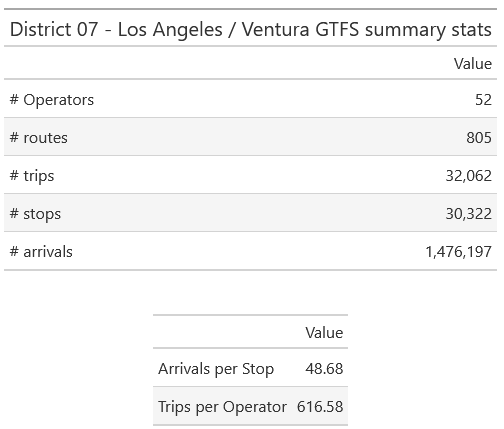

In [ ]:
group_fake_district = [
    "Eastern Contra Costa Transit Authority",
    "Alameda-Contra Costa Transit District",
    "Golden Gate Bridge, Highway and Transportation District",
    "Marin County Transit District",
    "City of Petaluma",
    "Presidio Trust",
    "Sonoma-Marin Area Rail Transit District",
    "San Francisco Bay Ferry and Oakland Alameda Water Shuttle Schedule",
    "Santa Clara Valley Transportation Authority",
    "City and County of San Francisco",
    "San Mateo County Transit District",
    "Sonoma County Transit Schedule",
    "City of Santa Rosa",
]

In [ ]:
df3 = df2.loc[
    (df2["Analysis Name"].isin(group_fake_district)) & (df2["Day Type"] == "Weekday")
]

In [ ]:
df3 = df3.sort_values(by=["Date"], ascending=False).drop_duplicates(
    subset=["Analysis Name"]
)

### Question for Tiffany: Where are the stops and arrivals 

In [ ]:
ct_district_summary1 = (
    df3.agg(
        {
            "Analysis Name": "nunique",
            "N Routes": "sum",
            "N Trips": "sum",
        }
    )
    .to_frame()
    .reset_index()
    .rename(columns={"index": "Category", 0: "Totals"})
)

In [ ]:
ct_district_summary1.Category = (
    ct_district_summary1.Category.str.replace("N Routes", "# Routes", "N Trips": "# Trips")
    .str.replace("Analysis Name", "# Operators")
)

In [ ]:
ct_district_summary1

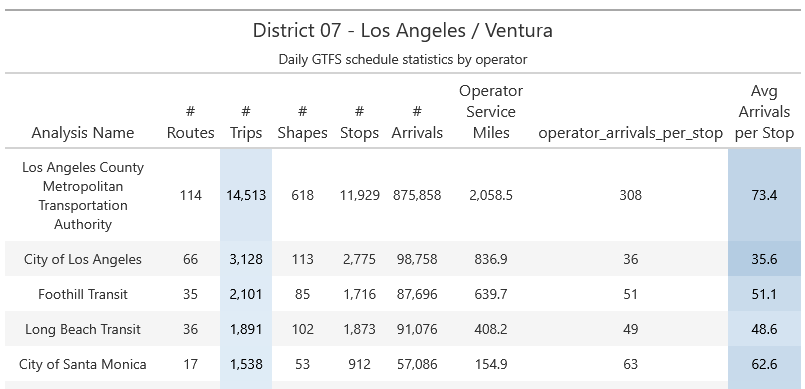
**Question: Can't find # of Shapes, Stops, Arrivals, Operator_Arrivals_Per_Stop, Avg Arrival per Stop**

In [ ]:
df3.sample()

In [ ]:
df3[["Analysis Name", "N Routes", "N Trips"]].sort_values(by=["Analysis Name"])

## Legislative District
**Same process as above but grouping it differently**
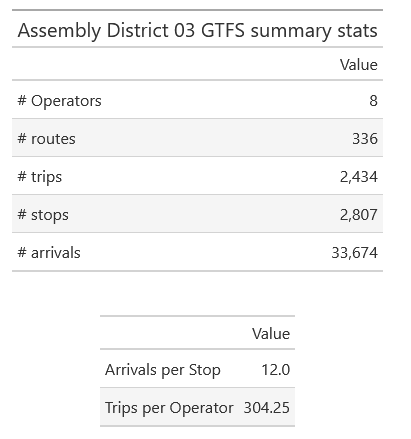

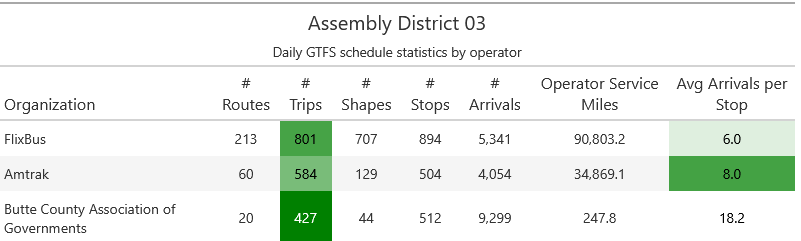